In [23]:
import re
import numpy as np
import countrycode
import phonenumbers
from phonenumbers.phonenumberutil import region_code_for_number

In [2]:
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm_notebook
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from pathlib import Path

plt.rcParams["figure.figsize"] = (20, 20)

In [29]:
argentina_area_codes = pd.read_csv("./argentina-area-codes.csv")

## Load toxicity model

In [3]:
from detoxify import Detoxify
model = Detoxify('multilingual')
results = model.predict(['jajajajajaja que hijo de puta'])
results

/home/juan/WhatsappAnalyzer/mundialdelectura/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'toxicity': [0.9959450364112854],
 'severe_toxicity': [0.019979896023869514],
 'obscene': [0.1270299106836319],
 'identity_attack': [0.022107917815446854],
 'insult': [0.10652615875005722],
 'threat': [0.004996316507458687],
 'sexual_explicit': [0.16550682485103607]}

In [4]:
def get_toxicity(message):
  return model.predict(message)["toxicity"]

## READ FROM TXT FILE

In [11]:
path = Path("./Chat_as_DF.pkl")
if path.is_file():
    after_process = pd.read_pickle(path)

In [114]:
splitted_chat = []
with open("./Chat de WhatsApp con Mundial de Lectura/chats.txt", "r") as chat:
    all_chat = chat.read().replace("\n", " ")
    splitted_chat = re.findall("\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+[()\d\w\s-]+: [\s\S]*?(?=\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+|$)", all_chat)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3654/927023349.py:4: SyntaxWarning: invalid escape sequence '\d'
  splitted_chat = re.findall("\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+[()\d\w\s-]+: [\s\S]*?(?=\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+|$)", all_chat)


In [116]:
def get_argentina_region(code):
    rows = argentina_area_codes[argentina_area_codes["code"] == code]
    if len(rows):
        return list(rows["localidad"]), rows.iloc[-1]["provincia"]
    else:
        return None, None

In [81]:
get_argentina_region(1)

[None, None]

In [117]:
def process_line(line):
    #10/3/2024, 12:44 - +54 9 11 3763-1285: Muchas Gracias !!! Ya compre entradas.
    regex_result = re.search("^(\d{1,2}\/\d{1,2}\/\d{4}), (\d\d:\d\d) - (\+(\d*) (?:9 (\d*)|([()\d\w\s-]*))([()\d\w\s-]*)): ([\s\S]*)$", line)
    Message_Raw = line
    date = regex_result.group(1)
    time = regex_result.group(2)
    phone_number = phonenumbers.parse(regex_result.group(3))
    country = region_code_for_number(phone_number)
    argentina_province, argentina_town = get_argentina_region(int(regex_result.group(5))) if country == "AR" else (None,None)
    message = regex_result.group(8)
    toxicity = get_toxicity(message)
    date = datetime.strptime(f"{date} {time}", "%d/%m/%Y %H:%M")
    return pd.DataFrame([{
            "User": phone_number,
            "Country": country,
            "Message_Raw": Message_Raw,
            "Argentina_Province": argentina_province,
            "Argentina_Location": argentina_town,
            "Message_Clean": message,
            "Message_Only_Text": message.lower() ,
            "Toxicity": toxicity,
            "Date": date,
            "Hour": date.hour,
            "Day_of_Week": date.weekday()
           }])

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3654/178608156.py:3: SyntaxWarning: invalid escape sequence '\d'
  regex_result = re.search("^(\d{1,2}\/\d{1,2}\/\d{4}), (\d\d:\d\d) - (\+(\d*) (?:9 (\d*)|([()\d\w\s-]*))([()\d\w\s-]*)): ([\s\S]*)$", line)


In [104]:
phonenumbers.parse("+54 9 291 432-4646")

PhoneNumber(country_code=54, national_number=92914324646, extension=None, italian_leading_zero=None, number_of_leading_zeros=None, country_code_source=0, preferred_domestic_carrier_code=None)

In [ ]:
after_process = pd.DataFrame()
with tqdm_notebook(total=len(splitted_chat)) as progress_bar:
    for line in splitted_chat:
        try:
            processed_line = process_line(line)
            after_process = pd.concat([after_process, processed_line])
        except Exception as err:
            print(f"EXCEPTION {err} on line {line}")
            pass
        finally:
            progress_bar.update(1)
            
after_process.to_pickle("Chat_as_DF.pkl")

  0%|          | 0/7284 [00:00<?, ?it/s]

In [113]:
after_process

,User,Country,Message_Raw,Argentina_Province,Argentina_Location,Message_Clean,Message_Only_Text,Toxicity,Date,Hour,Day_of_Week
0,Country Code: 54 National Number: 92914324646,AR,"8/5/2024, 21:11 - +54 9 291 432-4646: Hasta dó...","[BAHIA BLANCA, CABILDO, CHASICO, MAYOR BURATOV...",BUENOS AIRES,Hasta dónde leemos para el viernes?,hasta dónde leemos para el viernes?,0.000402,2024-05-08 21:11:00,21,2
0,Country Code: 54 National Number: 91149164740,AR,"8/5/2024, 21:13 - +54 9 11 4916-4740: Acá el c...",[AMBA],AMBA,Acá el cronograma de lectura,acá el cronograma de lectura,0.001018,2024-05-08 21:13:00,21,2
0,Country Code: 54 National Number: 92914324646,AR,"8/5/2024, 21:20 - +54 9 291 432-4646: No puedo...","[BAHIA BLANCA, CABILDO, CHASICO, MAYOR BURATOV...",BUENOS AIRES,No puedo abrir el cronograma,no puedo abrir el cronograma,0.000642,2024-05-08 21:20:00,21,2
0,Country Code: 54 National Number: 93436101042,AR,"8/5/2024, 21:21 - +54 9 343 610-1042: Por que ...","[ALDEA BRASILERA, ALDEA EIGENFELD, ALDEA MARIA...",ENTRE RIOS,Por que no esta más fijado?,por que no esta más fijado?,0.005338,2024-05-08 21:21:00,21,2
0,Country Code: 54 National Number: 92914324646,AR,"8/5/2024, 21:21 - +54 9 291 432-4646: Lo q pas...","[BAHIA BLANCA, CABILDO, CHASICO, MAYOR BURATOV...",BUENOS AIRES,Lo q pasa es q voy borrando mjes xq son ciento...,lo q pasa es q voy borrando mjes xq son ciento...,0.461167,2024-05-08 21:21:00,21,2
...,...,...,...,...,...,...,...,...,...,...,...
0,Country Code: 54 National Number: 92314411016,AR,"10/5/2024, 16:28 - +54 9 2314 41-1016: Me enca...","[BOLIVAR, ESPIGAS, HALE, HENDERSON, PIROVANO, ...",BUENOS AIRES,Me encantò!!! Gracias sss 💚,me encantò!!! gracias sss 💚,0.001636,2024-05-10 16:28:00,16,4
0,Country Code: 54 National Number: 92314411016,AR,"10/5/2024, 16:30 - +54 9 2314 41-1016: Es mara...","[BOLIVAR, ESPIGAS, HALE, HENDERSON, PIROVANO, ...",BUENOS AIRES,Es maravilloso este grupo! Y qué placer la lec...,es maravilloso este grupo! y qué placer la lec...,0.000527,2024-05-10 16:30:00,16,4
0,Country Code: 54 National Number: 91140844598,AR,"10/5/2024, 16:57 - +54 9 11 4084-4598: https:/...",[AMBA],AMBA,https://youtu.be/DbXLrkMFm8Q?si=HvWiLFqKP8fb_4Yx,https://youtu.be/dbxlrkmfm8q?si=hvwilfqkp8fb_4yx,0.000500,2024-05-10 16:57:00,16,4
0,Country Code: 54 National Number: 91140844598,AR,"10/5/2024, 16:58 - +54 9 11 4084-4598: No sé s...",[AMBA],AMBA,"No sé si alguien lo compartió ya, pero es un v...","no sé si alguien lo compartió ya, pero es un v...",0.000463,2024-05-10 16:58:00,16,4


## Messages sent by person

<Axes: xlabel='User'>

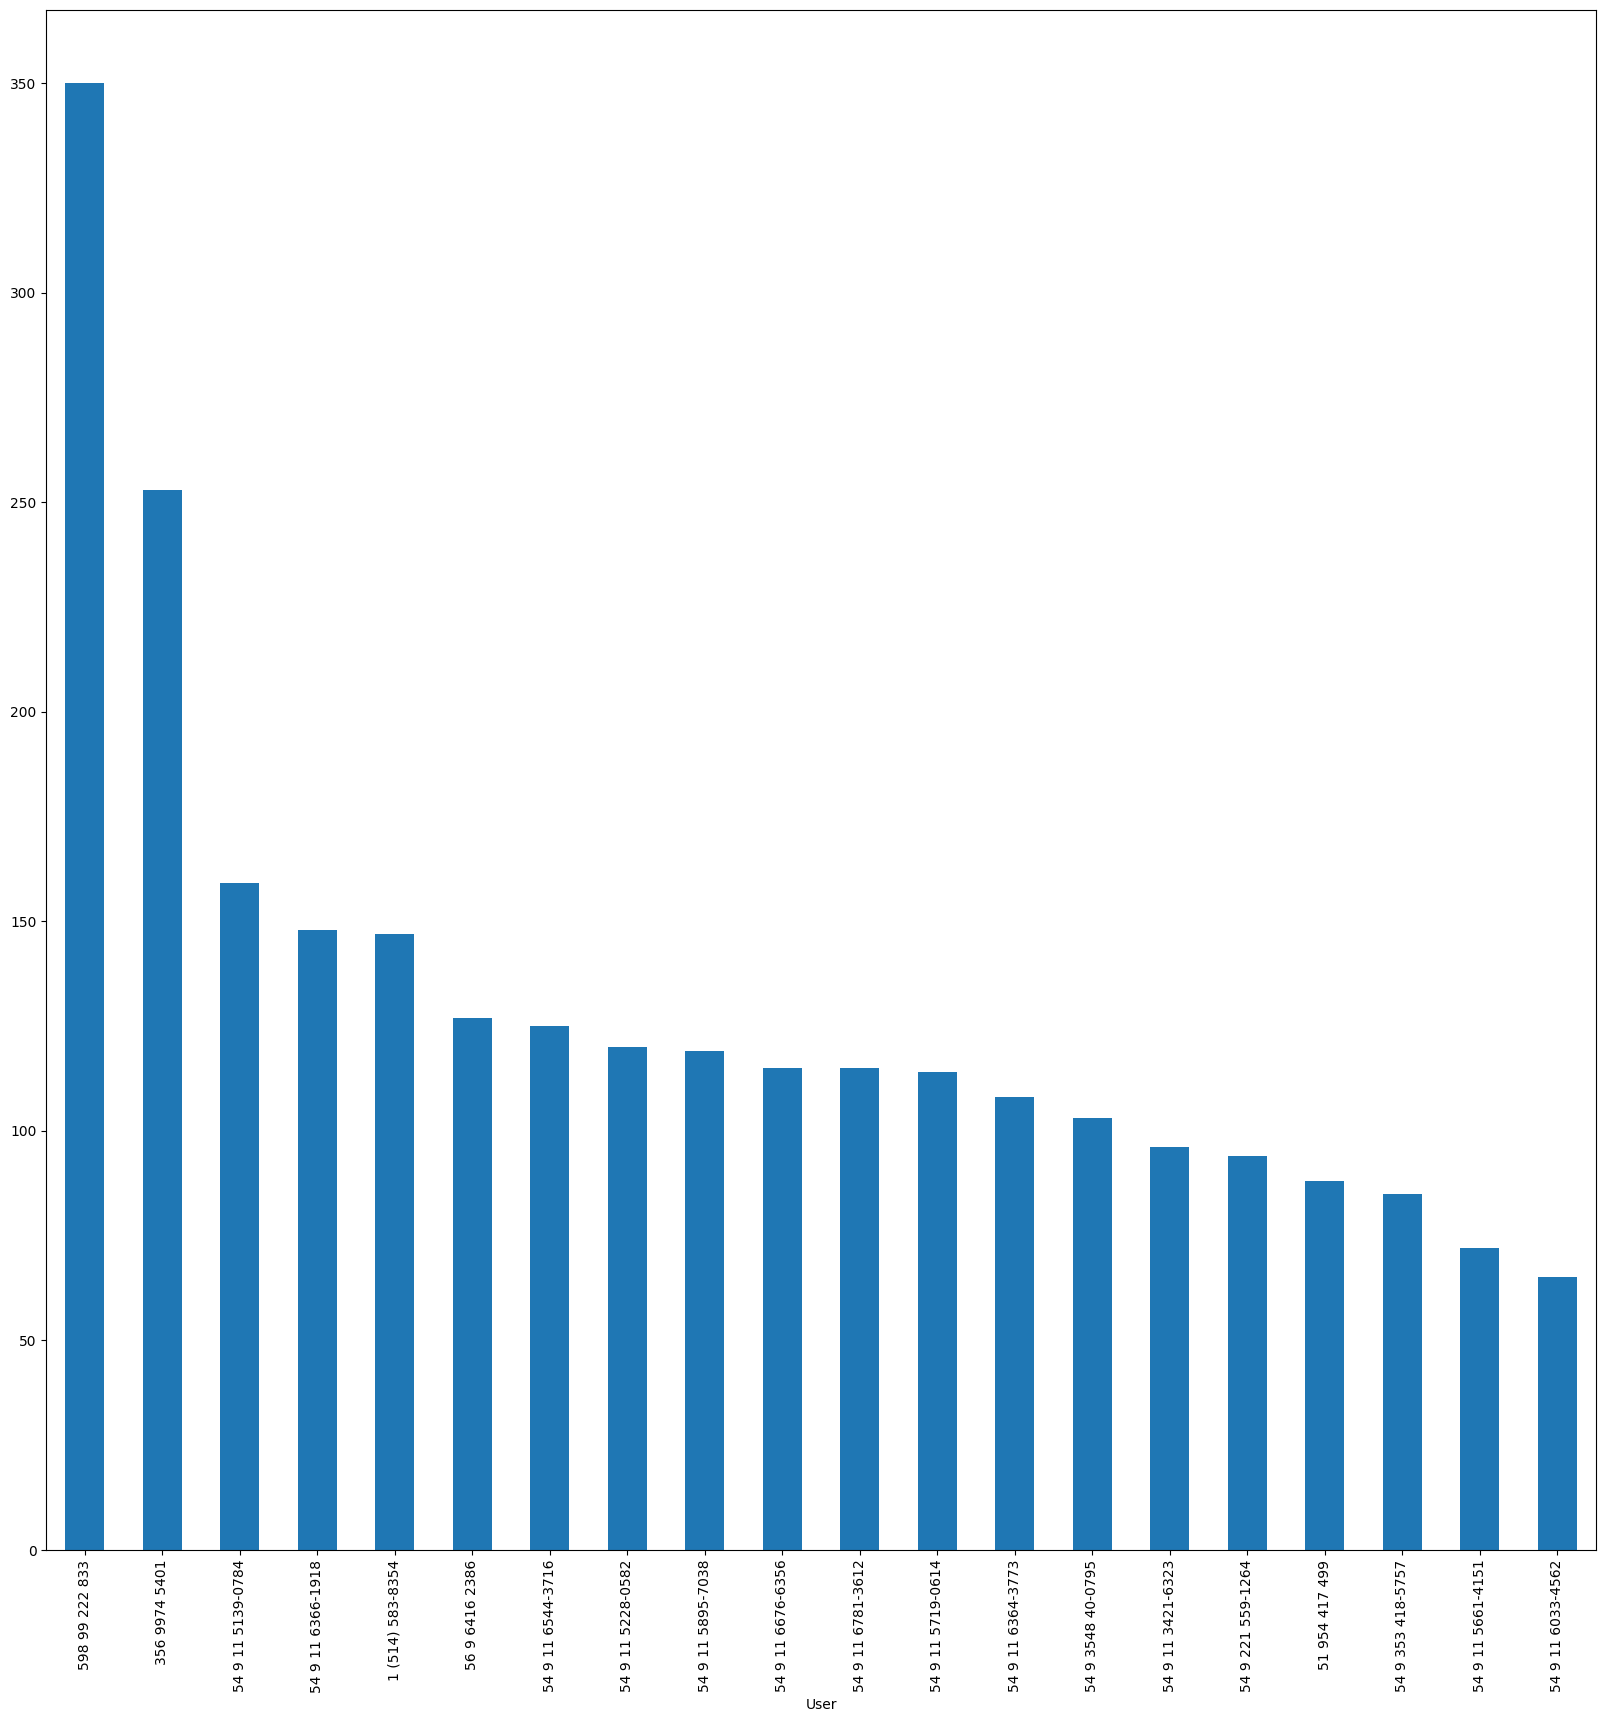

In [18]:
messages_by_person = after_process.groupby("User")
messages_by_person["User"].count().sort_values(ascending=False).head(20).plot(kind="bar")

## Get messages for a person

In [70]:
print(after_process[after_process["User"] == "54 9 221 602-2258"]["Message_Clean"])

NameError: name 'notebook' is not defined

## Day with max number of messages for each person

In [ ]:
max_messages_on_a_day_per_person = after_process.groupby(["User", after_process["Date"].dt.date]).count().sort_values(by="Hour").groupby(level=0).tail(1).sort_values(ascending=False, by="Hour")

max_messages_on_a_day_per_person["Date"].reset_index(name="Total messages")

## Day of the week with most messages for each person

In [ ]:
import calendar

messages_by_day_of_week = after_process.groupby(["User", after_process["Date"].dt.weekday]).count().sort_values(by="Hour")["Date"]

matrix_of_messages = messages_by_day_of_week.unstack()
matrix_of_messages.columns = map(lambda x: calendar.day_name[x],matrix_of_messages.columns)
matrix_of_messages.style.background_gradient(cmap="RdYlGn")

## Top 10 days with higher number of messages

In [19]:
higher_number_of_messages = after_process.groupby(after_process["Date"].dt.date).count()

for day in higher_number_of_messages.nlargest(columns="Hour", n=10).iterrows():
    print(f'Day (YYYY-MM-dd): {day[0]} - Number of messages: {day[1]["Hour"]}')

Day (YYYY-MM-dd): 2024-03-14 - Number of messages: 355
Day (YYYY-MM-dd): 2024-03-21 - Number of messages: 321
Day (YYYY-MM-dd): 2024-03-13 - Number of messages: 307
Day (YYYY-MM-dd): 2024-05-03 - Number of messages: 282
Day (YYYY-MM-dd): 2024-03-19 - Number of messages: 279
Day (YYYY-MM-dd): 2024-04-08 - Number of messages: 268
Day (YYYY-MM-dd): 2024-03-15 - Number of messages: 237
Day (YYYY-MM-dd): 2024-03-27 - Number of messages: 234
Day (YYYY-MM-dd): 2024-03-20 - Number of messages: 232
Day (YYYY-MM-dd): 2024-03-22 - Number of messages: 211


## Hour with the higher number of messages overall

In [20]:
higher_number_of_messages_of_hour = after_process.groupby(after_process["Date"].dt.hour).count()


print(f'Hour: {higher_number_of_messages_of_hour.idxmax()["Date"]} - Number of messages: {higher_number_of_messages.max()["Date"]}')

Hour: 10 - Number of messages: 355


## Most messages in an hour

In [21]:
higher_number_of_messages = after_process.groupby([after_process["Date"].dt.date, after_process["Date"].dt.hour]).count()

print(f'Day (YYYY-MM-dd): {higher_number_of_messages.idxmax()["Date"][0]} - Hour: {higher_number_of_messages.idxmax()["Date"][1]} - Number of messages: {higher_number_of_messages.max()["Date"]}')

Day (YYYY-MM-dd): 2024-04-08 - Hour: 8 - Number of messages: 65


## Messages per hour

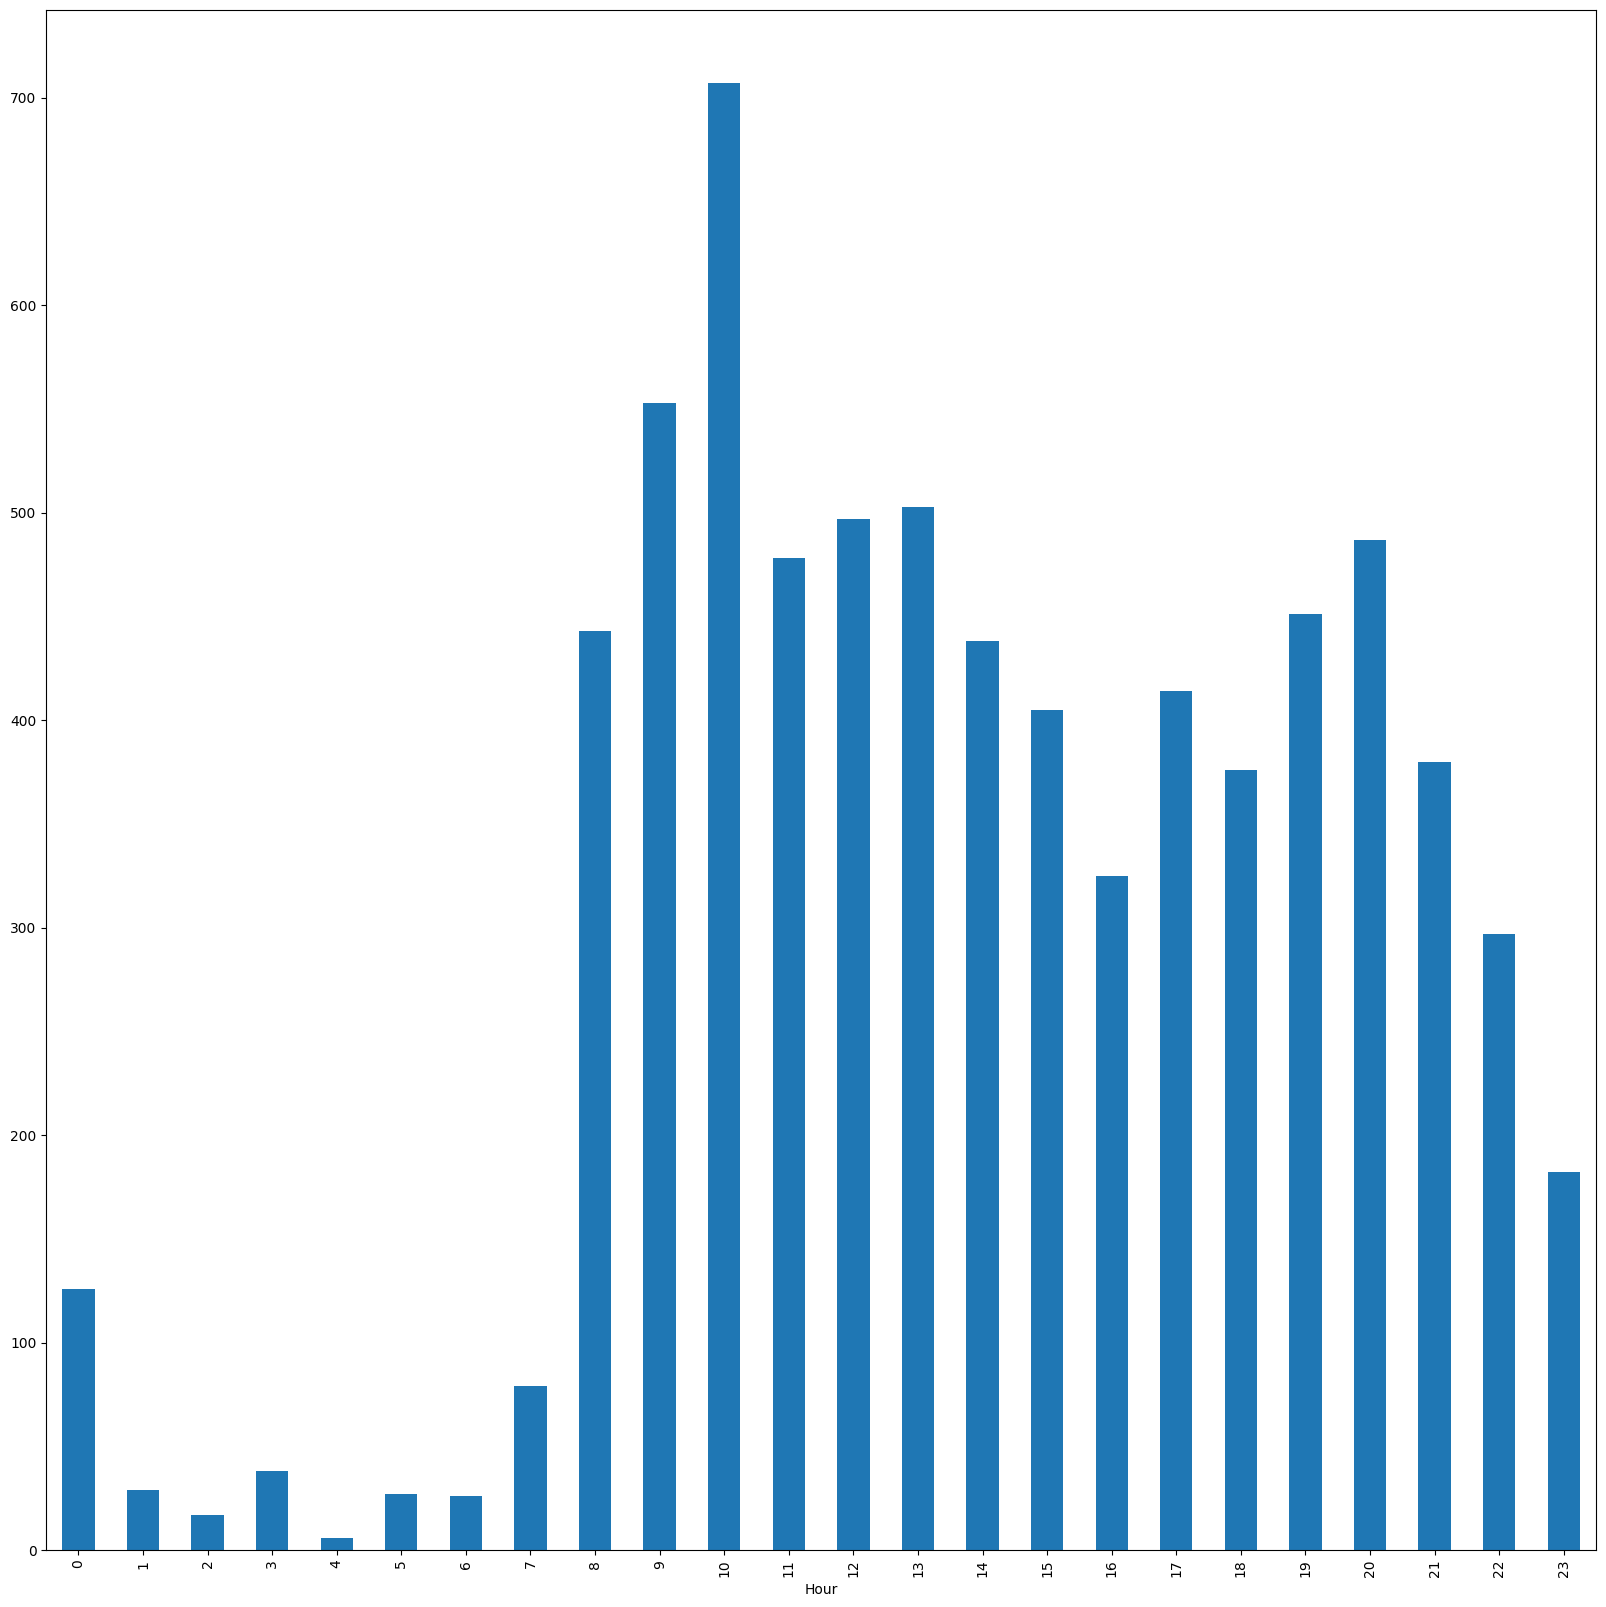

In [22]:
messages_per_hour = after_process.groupby("Hour")["Hour"].count().plot(kind="bar")

## Messages per day of the week

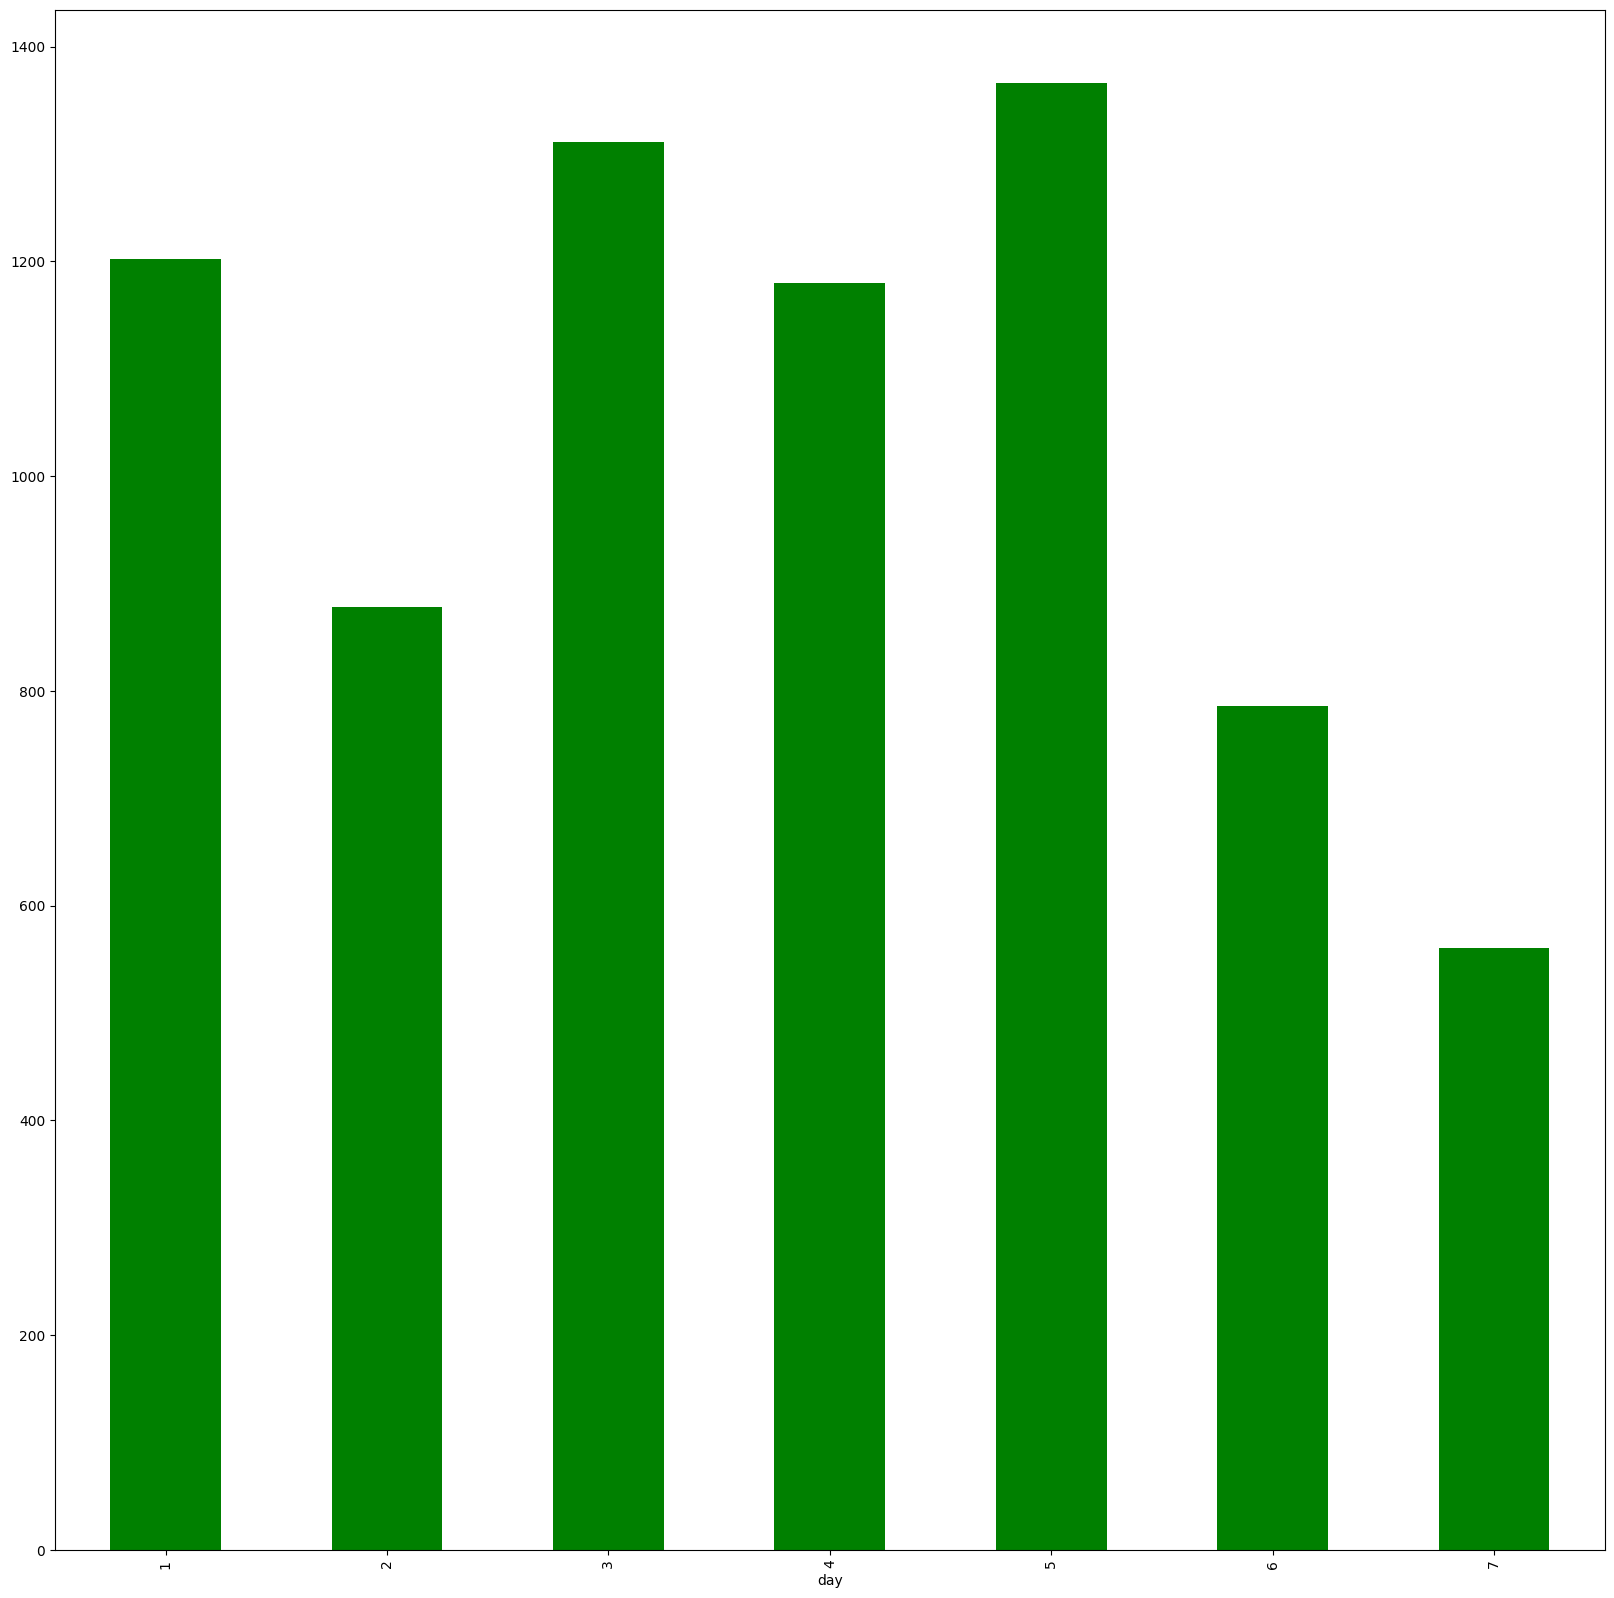

In [23]:
messages_per_hour = after_process.groupby(after_process["Date"].dt.isocalendar().day)["Hour"].count().plot(kind="bar", color="green")

## Messages per week of the each year

array([<Axes: title={'center': '2024'}, xlabel='Date'>], dtype=object)

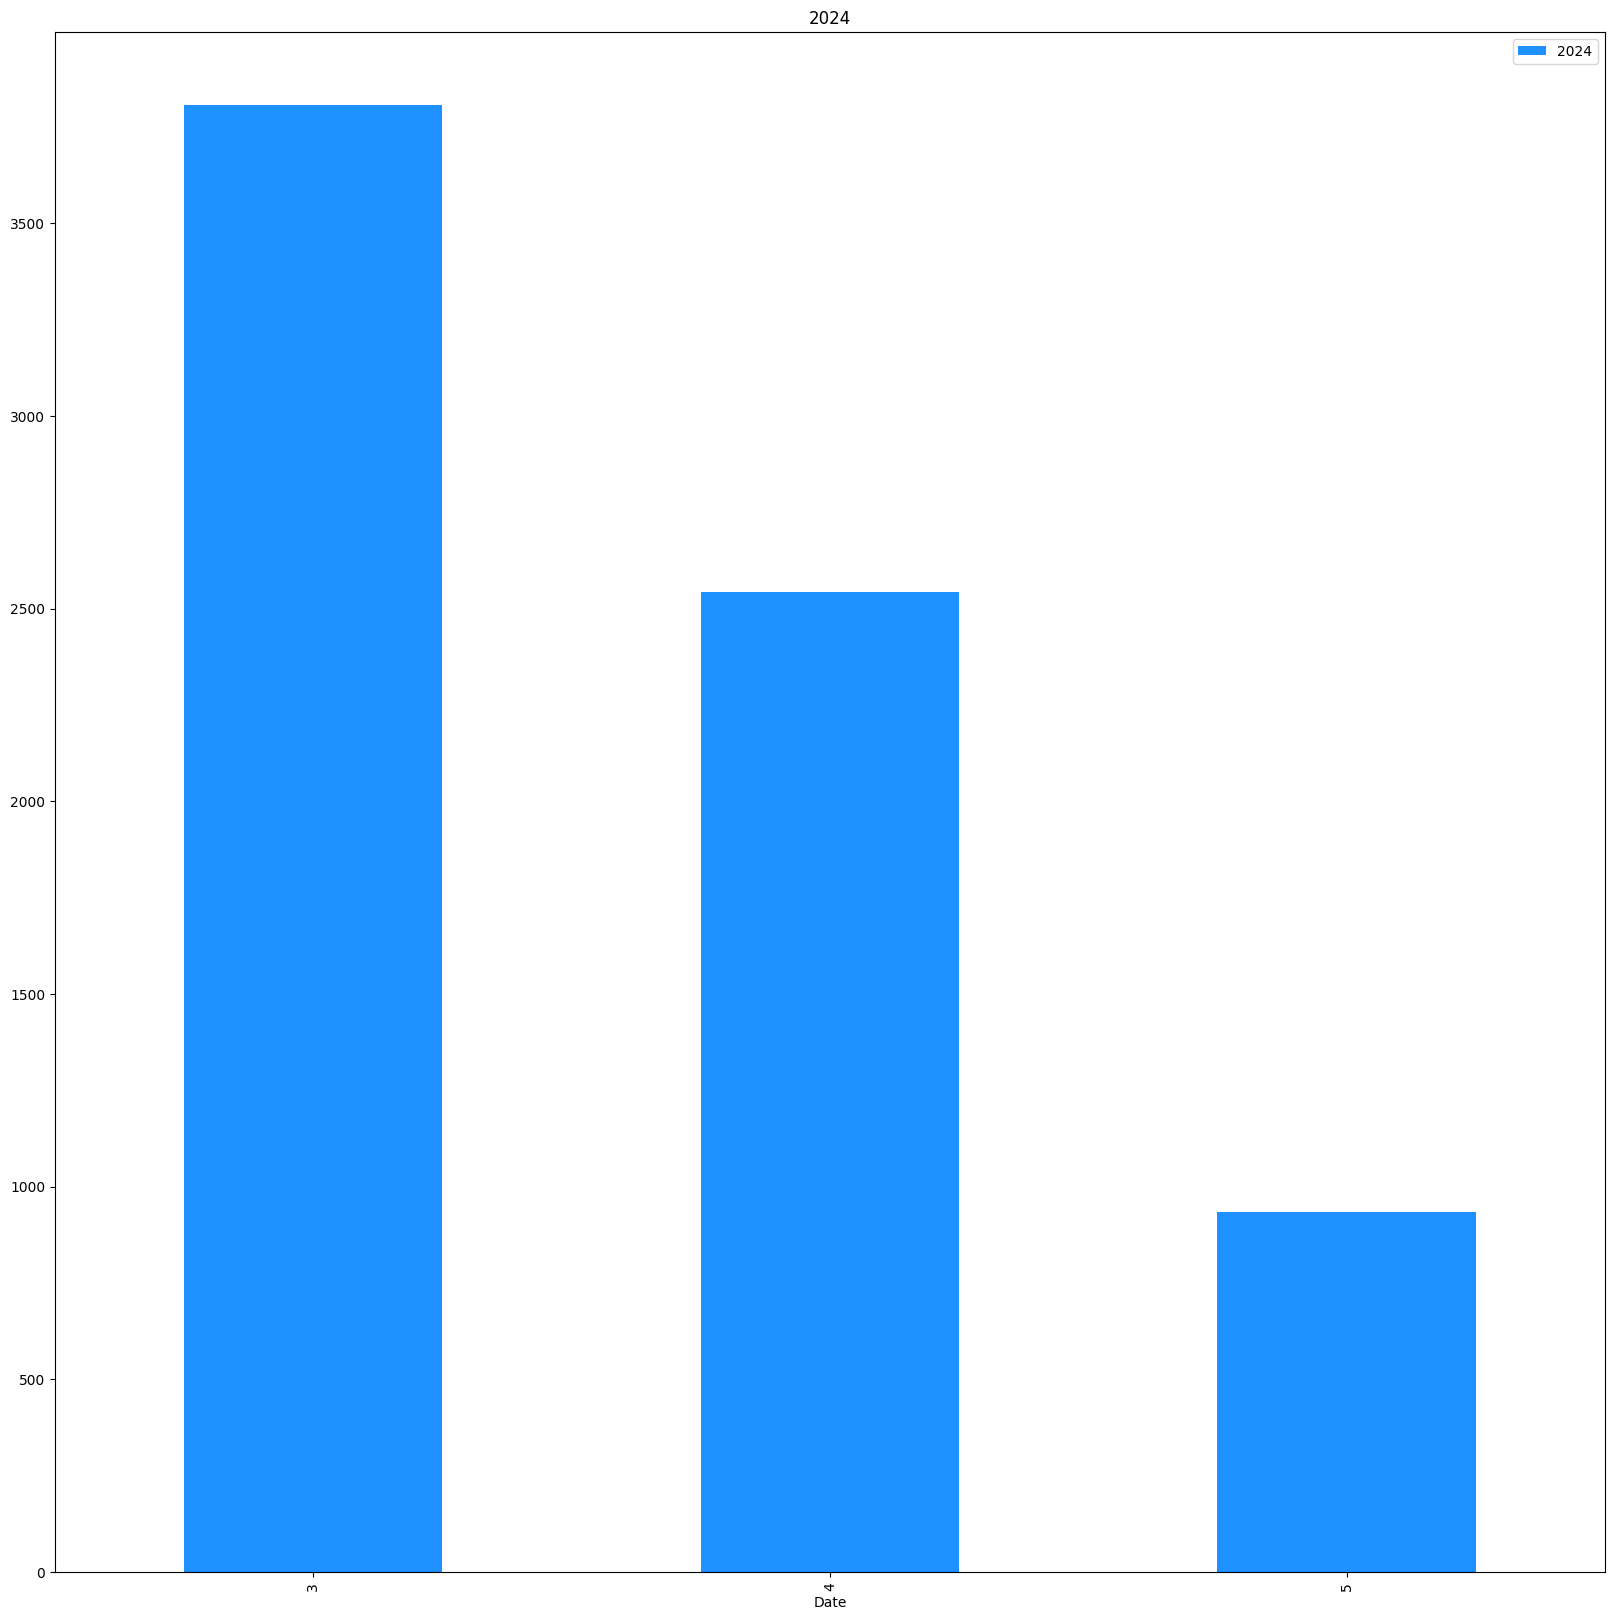

In [24]:
after_process.groupby([after_process["Date"].dt.month, after_process["Date"].dt.year])["Hour"].count().unstack(level=1).plot(kind="bar", color="dodgerblue", subplots=True)

In [38]:
column_aggregation = {
    "avg_message_length": lambda x: np.mean(x["Message_Clean"].str.len()),
    "total_char_length": lambda x: np.sum(x["Message_Clean"].str.len()),
    "total_messages": lambda x: len(x)
}
messages_aggregated = pd.DataFrame()
for label, function in column_aggregation.items():
    messages_aggregated[label] = messages_by_person.apply(function)

/tmp/ipykernel_5282/2570549389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  messages_aggregated[label] = messages_by_person.apply(function)
/tmp/ipykernel_5282/2570549389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  messages_aggregated[label] = messages_by_person.apply(function)
/tmp/ipykernel_5282/2570549389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Th

In [41]:
messages_aggregated.sort_values("avg_message_length",ascending=False)

,avg_message_length,total_char_length,total_messages
User,,,
54 9 221 602-2258,594.5,1189,2
54 9 11 5920-4058,555.0,555,1
54 9 11 6897-6797,551.0,551,1
54 9 11 5165-9032,488.0,488,1
54 9 261 360-1318,457.0,457,1
...,...,...,...
54 9 351 300-9517,8.5,17,2
54 9 291 506-1120,8.0,8,1
54 9 261 513-5247,8.0,8,1


## Average length per person

In [42]:
messages_aggregated.sort_values("avg_message_length",ascending=False).style.background_gradient(cmap="RdYlGn")

,avg_message_length,total_char_length,total_messages
User,,,
54 9 221 602-2258,594.500000,1189,2
54 9 11 5920-4058,555.000000,555,1
54 9 11 6897-6797,551.000000,551,1
54 9 11 5165-9032,488.000000,488,1
54 9 261 360-1318,457.000000,457,1
54 9 291 432-4646,397.459459,14706,37
54 9 2923 54-1692,356.605263,13551,38
54 9 11 3660-8965,349.277778,6287,18
54 9 11 5938-4978,324.400000,3244,10


## Amount of characters written by each person

In [43]:
messages_aggregated.sort_values("total_char_length",ascending=False).style.background_gradient(cmap="RdYlGn")

,avg_message_length,total_char_length,total_messages
User,,,
598 99 222 833,106.694286,37343,350
356 9974 5401,139.252964,35231,253
54 9 11 5895-7038,239.588235,28511,119
1 (514) 583-8354,185.598639,27283,147
54 9 11 5228-0582,134.241667,16109,120
56 9 6416 2386,124.818898,15852,127
598 99 633 276,285.660377,15140,53
54 9 291 432-4646,397.459459,14706,37
54 9 2923 54-1692,356.605263,13551,38


In [ ]:
message_counter =  Counter(after_process["User"])

In [ ]:
message_counter

## Who laugh the most?

In [44]:
def is_laugh(message):
  reg = re.compile(r"^.*\b[JjeEiIAakKSs]{3,}\b.*$")
  is_jj = re.compile(r"^.*\b[jJ][jJ]\b.*$")
  return bool(reg.match(message)) and bool(not is_jj.match(message))

In [45]:
count_laughs = dict.fromkeys(keys, 0)

for person, messages in messages_by_person:
  print(person)
  for message in messages.iterrows():
    if is_laugh(message[1]["Message_Clean"]):
      count_laughs[person] += 1

plt.bar(list(keys), list(count_laughs.values()))
plt.title("Who laugh the most overall?")
plt.xticks(rotation=90)
plt.show()

print(count_laughs)


NameError: name 'keys' is not defined

In [ ]:
average_laughs = dict.fromkeys(akas_for_each_person.keys(), 0)
for person in count_laughs:
  average_laughs[person] = count_laughs[person] / len(messages_by_person.get_group(person))

plt.bar(list(keys), list(count_laughs.values()))
plt.title("Who laugh the most (probability per message)?")
plt.xticks(rotation=90)
plt.show()

## Average toxicity by person

<Axes: xlabel='User'>

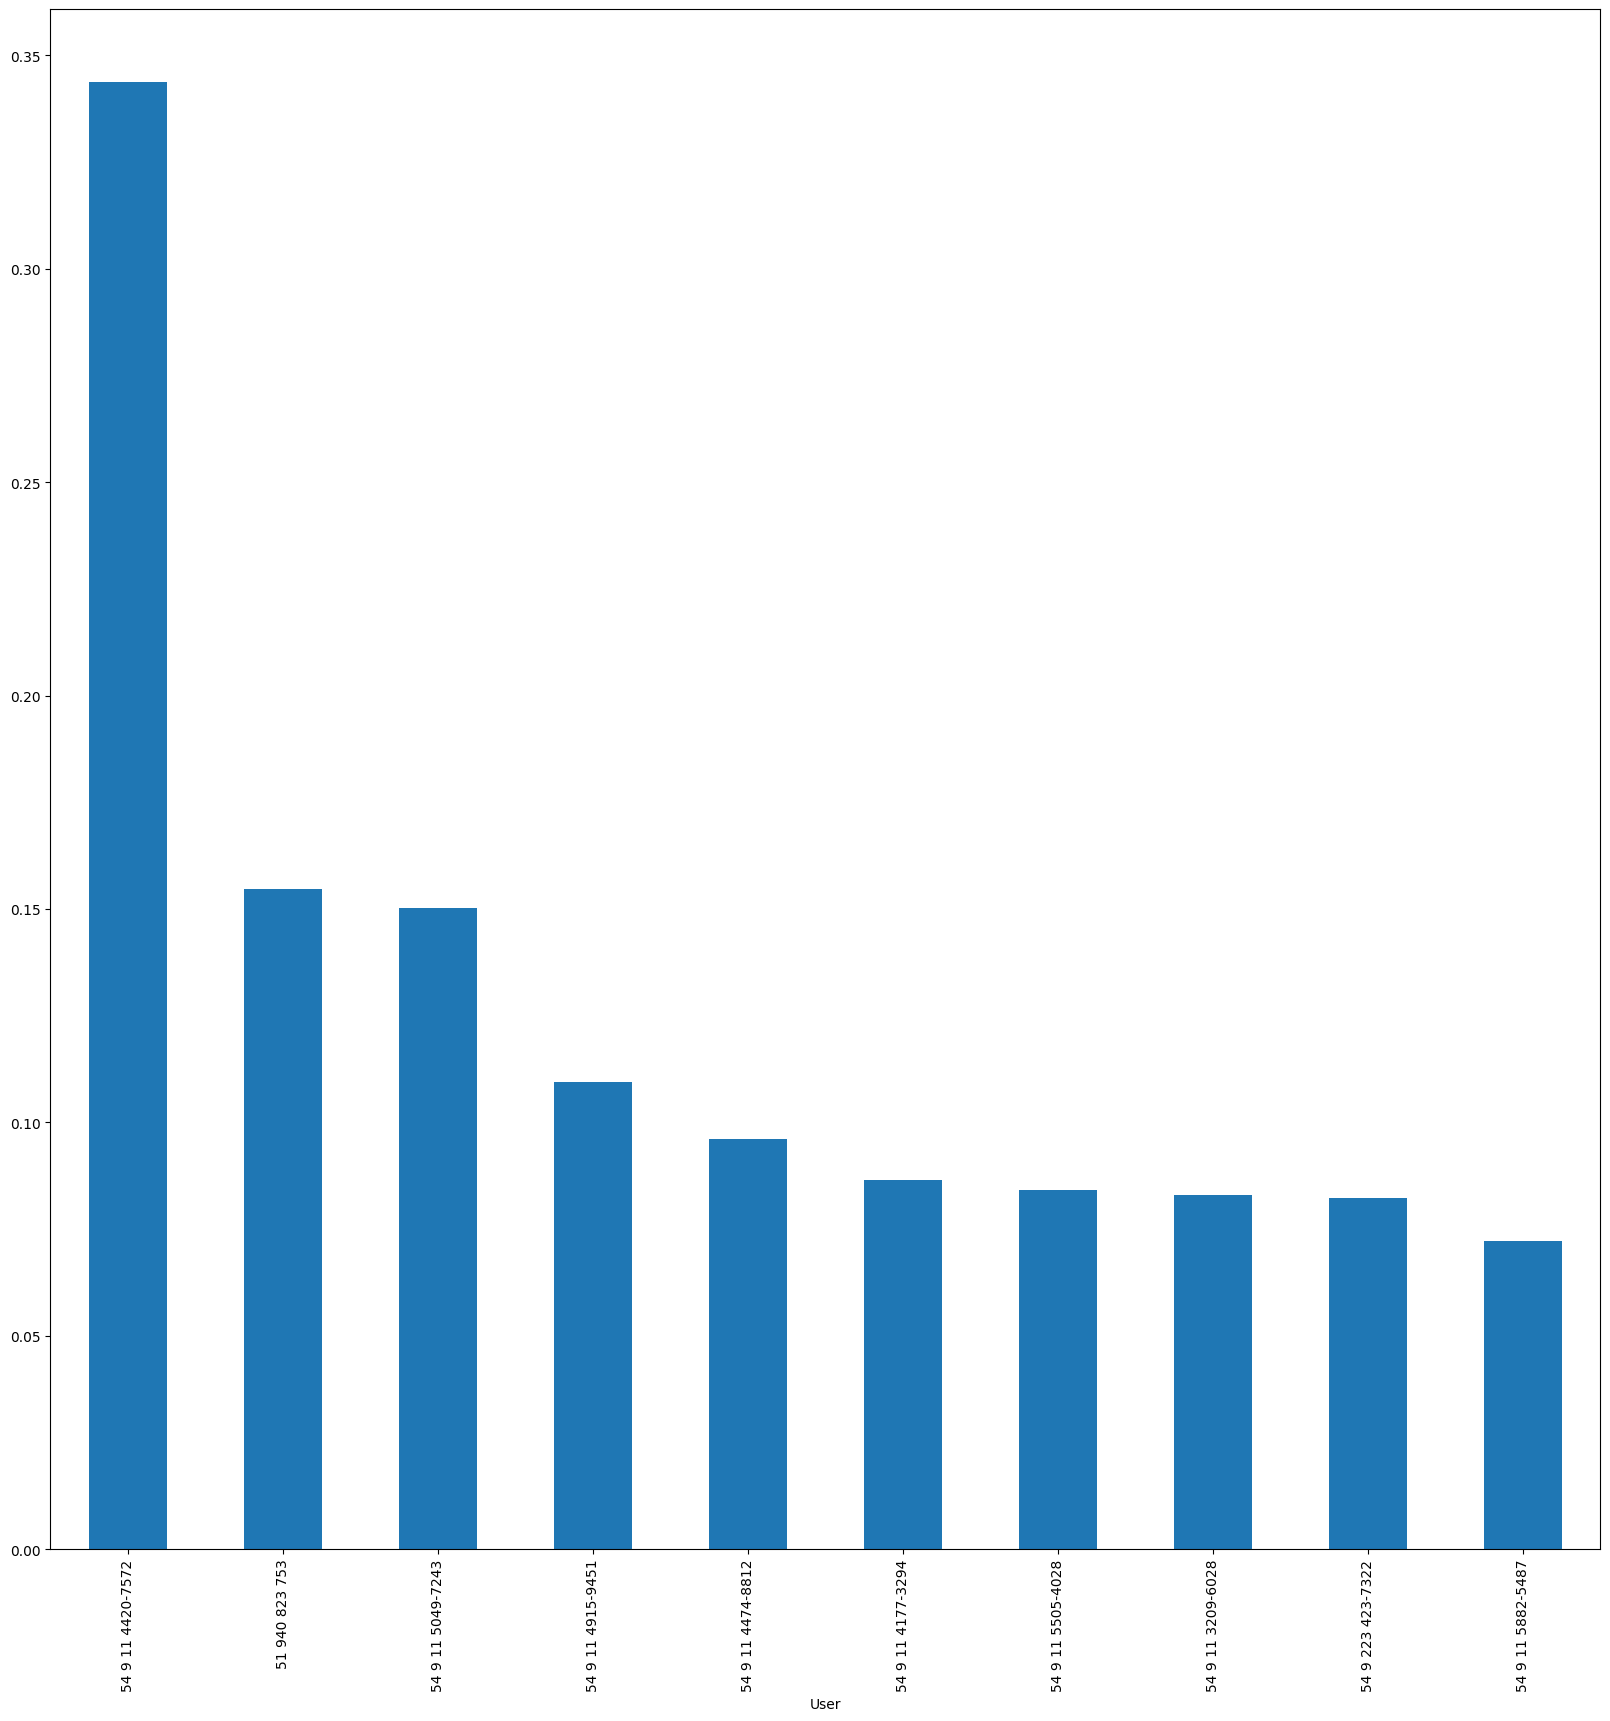

In [60]:
toxic_messages = after_process.groupby("User").mean(numeric_only=True)
toxic_messages["Toxicity"].sort_values(ascending=False).head(10).plot(kind="bar")

### Top 10 most toxic messages

In [48]:
after_process.nlargest(10, "Toxicity")[["Message_Clean", "Toxicity"]].reset_index()

,index,Message_Clean,Toxicity
0,0,Me desvelo sus estúpidos y desubicados comenta...,0.988293
1,0,😅😅 Tenía que ser argentino el muy maldito!,0.980533
2,0,Corto mano corto fierro cuando te mueras vas a...,0.979675
3,0,Dos una cobarde que eliminaste todos tus dicho...,0.976592
4,0,En el sonido y la furia hay un protagonista br...,0.964557
5,0,No voy a dejar de escribir porque una idiota m...,0.964308
6,0,"Hay algo que está más allá de ser peronista, m...",0.950384
7,0,Me parece que la gula de Dante se relaciona al...,0.940821
8,0,"No soy una cobarde, los elimine porque a difer...",0.931517
9,0,LAGO PUELO CUNA DEL LÚPULO Y PEJERREY,0.931170


In [ ]:
from nltk.corpus import stopwords
import nltk
spanish_stopwords = stopwords.words("spanish")
spanish_stopwords.extend(["q", "dsp", "si", "<", ">", "multimedia", "omitido", "omitida", "\u200eaudio", "\u200eimagen", "\u200esticker", "\u200evideo", "\u200egif", "", "Hola", "t", "d", ""])

In [ ]:
nltk.download("punkt")

In [ ]:
import spacy
import spacy_spanish_lemmatizer
nlp = spacy.load("es_core_news_sm")

In [ ]:
import string

In [ ]:
def lemmatize(message):
    return [token.lemma_ for token in nlp(message)]

def remove_word(word):
    return word in spanish_stopwords or is_laugh(word) or len(word) <= 3

def process_message(message):
    return [ token for token in nltk.word_tokenize(message.translate(str.maketrans('', '', string.punctuation))) if not remove_word(token.lower()) ]

In [ ]:
process_message("Hola, como estas vos?")

In [ ]:
messages_without_stopwords = []
for index, message in after_process.iterrows():
    new_message = message.copy()
    new_message["Message_Only_Text"] = " ".join(process_message(message["Message_Only_Text"]))
    messages_without_stopwords.append(new_message)

## Most frequently used words per person

In [49]:
messages_per_person_without_stopwords = dict.fromkeys(keys, [])
for person, messages in messages_by_person:
    for message in messages.iterrows():
        new_message = process_message(message[1]["Message_Only_Text"])
        messages_per_person_without_stopwords[person].extend(new_message)

NameError: name 'keys' is not defined

In [ ]:
most_used_words = dict.fromkeys(akas_for_each_person.keys(), 0)
for person in messages_per_person_without_stopwords:
    print(person)
    most_used_words[person] = Counter(messages_per_person_without_stopwords[person])

In [ ]:
Counter(messages_per_person_without_stopwords["Person2"]).most_common(10)